In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patheffects as PathEffects

In [2]:
from uriel import Uriel
u = Uriel(load=True, umap=True)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


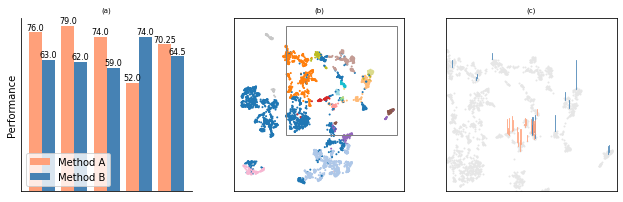

In [3]:
plt.rcParams["figure.figsize"] = (9,3)
from papers import papers
from matplotlib.patches import Rectangle

fig, axes = plt.subplots(1, 3)
plt.subplots_adjust(wspace=0.1)

labels = ['Spanish', 'Catalan', 'Portugese', 'Persian', 'Average']
a_means = [85, 65, 83, 45]
a_means = [76, 79, 74, 52]
a_means.append(np.mean(a_means))
b_means = [81, 60, 79, 52]
b_means = [63, 62, 59, 74]
b_means.append(np.mean(b_means))

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig.tight_layout()
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
rects1 = axes[0].bar(x - width/2, a_means, width, label='Method A', color='lightsalmon')
rects2 = axes[0].bar(x + width/2, b_means, width, label='Method B', color='steelblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
axes[0].set_ylabel('Performance')
axes[0].set_xticks(x)
axes[0].tick_params(axis='x', which='major', labelsize=9)
axes[0].set_xticklabels(labels)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        axes[0].annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),
                    textcoords="offset points",
                    ha='center', va='bottom', color='black', fontsize=8)


autolabel(rects1)
autolabel(rects2)

axes[0].legend(loc=3)

for ax, c in zip(axes, 'abc'):
    ax.set_xticks([])
    ax.set_yticks([])
    eh = ax.set_title(f'({c})', fontsize=7)

axes[1].scatter(u.umap_vectors.embedding_[:,0], u.umap_vectors.embedding_[:,1],
            c=u.language_metadata(u.uriel_languages)['label'],
            s=1,
            cmap='tab20')
axes[1].add_patch(Rectangle((4, 2), 20, 20, fill=False, edgecolor='gray'),)

rahimi_lang, rahimi_scores = papers['rahimi_ner']
heinzer_lang, heinzer_scores = papers['heinzerling_pos']

cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 4]
cut = cut[cut[:, 0] < 24]
cut = cut[cut[:, 1] > 2]
cut = cut[cut[:, 1] < 22]

score1 = dict(zip(rahimi_lang, rahimi_scores[:, 2]))
score2 = dict(zip(rahimi_lang, rahimi_scores[:, 11]))
metadata = u.language_metadata(u.uriel_languages)
metadata = metadata[metadata['code'].isin(rahimi_lang)]
diff = {l: score2[l] / score1[l] - 1 for l in metadata['code']}
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[diff[l] for l in metadata['code']],
    color=['#66ee66' if diff[l] > 0 else '#ee6666' for l in metadata['code']],
)
metadata['height'] /= max(metadata['height'])
metadata['height'] *= 2

axes[2].scatter(cut[:, 0], cut[:, 1], s=1, c=(0.9, 0.9, 0.9))
for x, y, h in zip(metadata['x'], metadata['y'], metadata['height'],):
    if h > 0:
        axes[2].plot([x, x], [y, y+h], c='lightsalmon', linewidth=0.8)
    else:
        axes[2].plot([x, x], [y, y-h], c='steelblue', linewidth=0.8) 

axes[2].set_xlim((4, 24))
axes[2].set_ylim((2, 22))

plt.savefig('fig2.pdf', bbox_inches='tight')

In [ ]:
plt.rcParams["figure.figsize"] = (3,3)
from papers import papers
from matplotlib.patches import Rectangle

rahimi_lang, rahimi_scores = papers['heinzerling_pos']

cut = u.umap_vectors.embedding_
cut = cut[cut[:, 0] > 4]
cut = cut[cut[:, 0] < 24]
cut = cut[cut[:, 1] > 2]
cut = cut[cut[:, 1] < 22]

score1 = dict(zip(rahimi_lang, rahimi_scores[:, 0]))
score2 = dict(zip(rahimi_lang, rahimi_scores[:, 10]))
metadata = u.language_metadata(u.uriel_languages)
metadata = metadata[metadata['code'].isin(rahimi_lang)]
diff = {l: score2[l] / score1[l] - 1 for l in metadata['code']}
metadata = metadata.assign(
    x=u.umap_vectors.embedding_[metadata.index][:,0],
    y=u.umap_vectors.embedding_[metadata.index][:,1],
    width=0.05,
    height=[diff[l] for l in metadata['code']],
    color=['#66ee66' if diff[l] > 0 else '#ee6666' for l in metadata['code']],
)
metadata['height'] /= max(metadata['height'])
metadata['height'] *= 2

plt.scatter(cut[:, 0], cut[:, 1], s=1, c=(0.9, 0.9, 0.9))
for x, y, h in zip(metadata['x'], metadata['y'], metadata['height'],):
    if h > 0:
        plt.plot([x, x], [y, y+h], c='lightsalmon', linewidth=0.8)
    else:
        plt.plot([x, x], [y, y-h], c='steelblue', linewidth=0.8) 

plt.xlim = (4, 24)
plt.ylim = (2, 22)
plt.tick_params(left = False, labelleft = False, bottom=False, labelbottom = False)
plt.savefig('fig4.pdf', bbox_inches='tight')

In [ ]:
from visualizations import show_uriel

show_uriel(u)

In [ ]:
from matplotlib.collections import LineCollection
plt.rcParams["figure.figsize"] = (4, 7)

languages, scores = papers['rahimi_ner']
family = {'Germanic', 'Italic', 'Slavic'}

fig, axes = plt.subplots(2, 1)
plt.subplots_adjust(hspace=0.4)
for ax, languages, scores, red, green, title in zip(axes, *zip(papers['rahimi_ner'], papers['heinzerling_pos']), [2, 0], [11, 10], ['Rahimi et al.', 'Heinzerling and Strube']):
    xs = np.mean(scores, axis=0)        
    ys = np.mean(scores[
        [i
         for i, l
         in enumerate(languages)
         if not u.is_in_family(l, family)
        ]
    ], axis=0)
    col = LineCollection(segments=[[(0,0), (100,100)]], linewidths=1, colors='gray')
    ax.add_collection(col, autolim=False)
    colors = ['gray' for _ in range(len(xs))]
    colors[red] = 'steelblue'
    colors[green] = 'lightsalmon'
    ax.scatter(xs, ys, c=colors, s=3)
    ax.set_xlabel('Total average')
    ax.set_ylabel('Non-GIS average')
    ax.set_title(title)
    for i, xy in enumerate(zip(xs, ys)):     
        ax.annotate(
            text=i,
            xy=xy,
            xytext=(1, 1),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize='small')
plt.savefig('fig3.pdf', bbox_inches='tight')